In [ ]:
import torchvision
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


transform_train = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])


transform_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 훈련 데이터
print(train_dataset.data.shape, len(train_dataset.targets))
#print(train_dataset.targets)

# 테스트 데이터
print(test_dataset.data.shape, len(test_dataset.targets))
#print(test_dataset.targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

print('CIFAR10 ready~')

# CUDA setting
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

(50000, 32, 32, 3) 50000
(10000, 32, 32, 3) 10000
CIFAR10 ready~
cuda


In [ ]:
from torch import nn, optim

# (N, C, H, W) 형식의 탠서를 (N ， C* H *W) 로 늘리는 계층
# 합성곱 출력을 M LP에 전달할 때 띨요
class FlattenLayer(nn .Module):
  def forward(self, x):
    sizes = x.size()
    return x.view(sizes[0] , -1)


# resnet18 load
model = torch.load('resnet18_model.pt')


model.to(DEVICE)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 손실 함수 로그
train_losses = []
train_acces = []
valid_losses = []
valid_accses = []

# 10회 반복
for epoch in range(10):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])

  # train
  model.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = model(X)

    # CrossEntropyLoss 계산
    loss = loss_fn(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  model.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = model(X)

      # CrossEntropyLoss 계산
      loss = loss_fn(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_acces.append(np.mean(total_train_acc))
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set

Epoch:001 - train loss: 0.1909 acc: 0.9408 - valid loss: 0.2030 acc: 0.9516
Epoch:002 - train loss: 0.1297 acc: 0.9566 - valid loss: 0.1892 acc: 0.9530
Epoch:003 - train loss: 0.1101 acc: 0.9624 - valid loss: 0.2018 acc: 0.9494
Epoch:004 - train loss: 0.1026 acc: 0.9658 - valid loss: 0.1941 acc: 0.9505
Epoch:005 - train loss: 0.0959 acc: 0.9685 - valid loss: 0.1873 acc: 0.9534
Epoch:006 - train loss: 0.0938 acc: 0.9680 - valid loss: 0.1818 acc: 0.9537
Epoch:007 - train loss: 0.0842 acc: 0.9712 - valid loss: 0.1844 acc: 0.9529
Epoch:008 - train loss: 0.0854 acc: 0.9703 - valid loss: 0.1789 acc: 0.9541
Epoch:009 - train loss: 0.0819 acc: 0.9723 - valid loss: 0.1900 acc: 0.9515
Epoch:010 - train loss: 0.0791 acc: 0.9735 - valid loss: 0.1940 acc: 0.9517
Learning finished


In [ ]:

# resnet34 load
model = torch.load('resnet34_model.pt')
model.to(DEVICE)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 10회 반복
for epoch in range(10):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])
  # train
  model.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = model(X)

    # CrossEntropyLoss 계산
    loss = loss_fn(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  model.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = model(X)

      # CrossEntropyLoss 계산
      loss = loss_fn(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_acces.append(np.mean(total_train_acc))
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

Epoch:001 - train loss: 0.0670 acc: 0.9771 - valid loss: 0.1522 acc: 0.9594
Epoch:002 - train loss: 0.0673 acc: 0.9769 - valid loss: 0.1643 acc: 0.9582
Epoch:003 - train loss: 0.0639 acc: 0.9782 - valid loss: 0.1681 acc: 0.9596
Epoch:004 - train loss: 0.0665 acc: 0.9777 - valid loss: 0.1466 acc: 0.9603
Epoch:005 - train loss: 0.0591 acc: 0.9794 - valid loss: 0.1464 acc: 0.9623
Epoch:006 - train loss: 0.0650 acc: 0.9782 - valid loss: 0.1586 acc: 0.9585
Epoch:007 - train loss: 0.0619 acc: 0.9787 - valid loss: 0.1564 acc: 0.9585
Epoch:008 - train loss: 0.0597 acc: 0.9801 - valid loss: 0.1481 acc: 0.9602
Epoch:009 - train loss: 0.0629 acc: 0.9788 - valid loss: 0.1601 acc: 0.9572
Epoch:010 - train loss: 0.0599 acc: 0.9793 - valid loss: 0.1586 acc: 0.9573
Learning finished


In [ ]:

# resnet50 load
model= torch.load('resnet50_model.pt')
model.to(DEVICE)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 10회 반복
for epoch in range(10):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])

  # train
  model.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = model(X)

    # CrossEntropyLoss 계산
    loss = loss_fn(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  model.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = model(X)

      # CrossEntropyLoss 계산
      loss = loss_fn(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_acces.append(np.mean(total_train_acc))
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

Epoch:001 - train loss: 0.0671 acc: 0.9768 - valid loss: 0.1563 acc: 0.9593
Epoch:002 - train loss: 0.0703 acc: 0.9765 - valid loss: 0.1624 acc: 0.9567
Epoch:003 - train loss: 0.0679 acc: 0.9766 - valid loss: 0.1542 acc: 0.9601
Epoch:004 - train loss: 0.0642 acc: 0.9779 - valid loss: 0.1772 acc: 0.9570
Epoch:005 - train loss: 0.0595 acc: 0.9797 - valid loss: 0.1693 acc: 0.9592
Epoch:006 - train loss: 0.0690 acc: 0.9765 - valid loss: 0.1580 acc: 0.9585
Epoch:007 - train loss: 0.0608 acc: 0.9790 - valid loss: 0.1556 acc: 0.9595
Epoch:008 - train loss: 0.0609 acc: 0.9797 - valid loss: 0.1680 acc: 0.9590
Epoch:009 - train loss: 0.0605 acc: 0.9792 - valid loss: 0.1753 acc: 0.9566
Epoch:010 - train loss: 0.0605 acc: 0.9792 - valid loss: 0.1667 acc: 0.9587
Learning finished


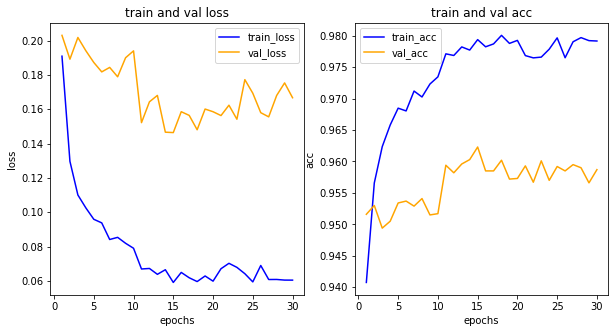

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, train_los, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_los, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_acces, color = 'blue', label = 'train_acc')
ax2.plot(epochs, valid_accses, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
torch.save(model, 'ResNet_ensemble2_model.pt')  # 전체 모델 저장
torch.save(model.state_dict(),'ResNet_ensenble2_model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, 'ResNet_ensemble2_all.tar')